In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import matplotlib.pyplot as plt
import torchvision

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
!pip install torchmetrics
from torchmetrics import Accuracy

## 2. Read data

In [3]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

### 2.1. Transform a row to tensor to visualize it

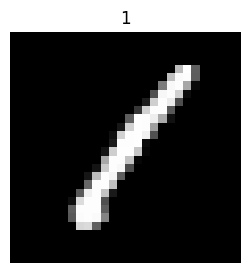

In [4]:
# First image
first_img = torch.Tensor(train_data.iloc[0, 1:].to_numpy())

# Visualize the first image
plt.figure(figsize=(5,3))

# Reshape image
first_img = torch.reshape(first_img, (28, 28)).unsqueeze(dim=0)

plt.axis(False)
plt.title(train_data.iloc[0, 0])
plt.imshow(first_img.permute(1,2,0), cmap='gray')

### 2.2. Visualize many images

In [5]:
len(train_data)

42000

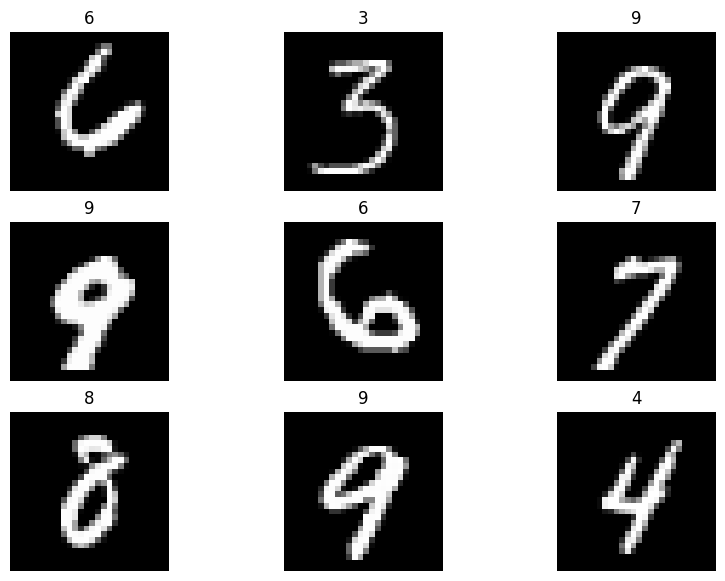

In [6]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_data), (9,))
n_rows, n_columns = 3, 3
idx = 1

plt.figure(figsize=(10,7))
for i in random_idx:
    
    pixels = train_data.iloc[int(i), 1:].to_numpy()
    img = torch.Tensor(pixels).to(torch.float)
    label = train_data.iloc[int(i), 0]
    
    # Reshape image
    img = torch.reshape(img, (28, 28)).unsqueeze(dim=0)

    plt.subplot(n_rows, n_columns, idx)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show
    
    idx += 1

### 2.3. Visualize test data

In [7]:
test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Test data doesn't have labels!

## 3. Create Dataloader


### 3.1. Create validation set

First we need to create a validation set because there is no labels in our test data

In [8]:
train_data['split'] = np.random.randn(train_data.shape[0], 1)

# We will create 80% train data and 20% validation data
msk = np.random.rand(len(train_data)) <= 0.8

val_data = train_data[~msk]
train_data = train_data[msk]

val_data = val_data.drop(columns=['split'])
train_data = train_data.drop(columns=['split'])

val_data.to_csv('validation.csv', index=False)
train_data.to_csv('train.csv', index=False)

In [9]:
len(train_data), len(val_data)

(33802, 8198)

In [10]:
val_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2. Create Dataset class and instantiate Dataloaders

In [12]:
# Train data shape
classes = train_data.label.unique()
classes

array([0, 1, 7, 3, 5, 8, 9, 6, 2, 4])

In [13]:
import torch.utils.data
import torchvision.transforms as transforms

class DigitRecognizerDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None, train=True):
        self.df = pd.read_csv(csv_file)
        if train:
            self.features_train = self.df.iloc[:, 1:].to_numpy().reshape(len(self.df), 28, 28).astype(np.uint8)
        else:
            self.features_test = self.df.to_numpy().reshape(len(self.df), 28, 28).astype(np.uint8)
        self.labels = torch.from_numpy(self.df.iloc[:, 0].to_numpy())
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if self.train:
            features = self.features_train[index]
            labels = self.labels[index]
            if self.transform:
                features = self.transform(features)
            return features, labels
        else:
            features = self.features_test[index]
            if self.transform:
                features = self.transform(features)
            return features

In [14]:
BATCH_SIZE = 32

train_data_object = DigitRecognizerDataset("train.csv", 
                                           transform=transforms.Compose([
                                                    transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_data_object,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

In [15]:
val_data_object = DigitRecognizerDataset("validation.csv",
                                        transform=transforms.Compose([
                                                    transforms.ToTensor()]))

val_loader = torch.utils.data.DataLoader(val_data_object,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

In [16]:
test_data_object = DigitRecognizerDataset("/kaggle/input/digit-recognizer/test.csv",
                                        transform=transforms.Compose([
                                                    transforms.ToTensor()]),
                                         train=False)

test_loader = torch.utils.data.DataLoader(test_data_object,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

In [17]:
len(train_loader), len(val_loader)

(1057, 257)

### Visualize if the DataLoader works

In [18]:
sample_img, sample_label = next(iter(train_loader))
sample_img.shape, sample_label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

<function matplotlib.pyplot.show(close=None, block=None)>

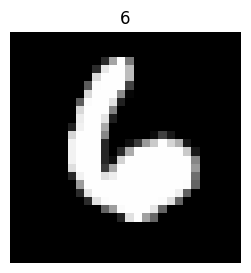

In [19]:
# Visualize the sample image
plt.figure(figsize=(5,3))
plt.imshow(sample_img[0].permute(1,2,0), cmap='gray')
plt.axis(False)
plt.title(sample_label[0].item())
plt.show

**It works!**

Let's check more images

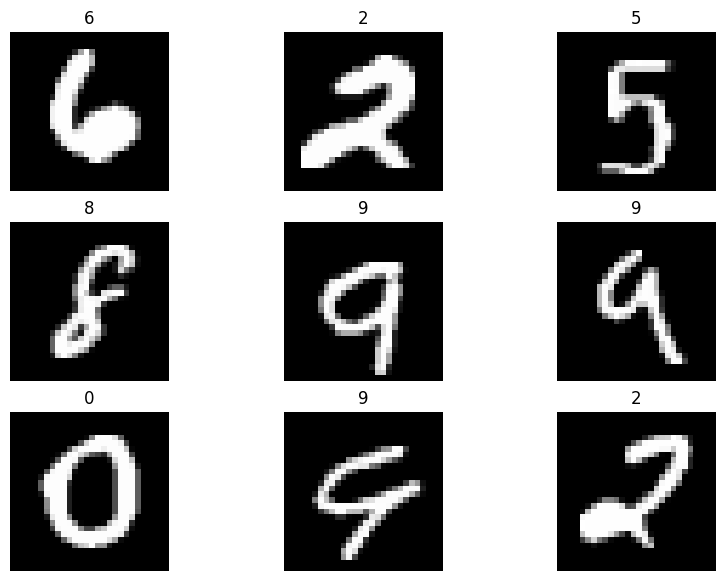

In [20]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_data), (9,))
n_rows, n_columns = 3, 3
idx = 1

sample_img, sample_label = next(iter(train_loader))
plt.figure(figsize=(10,7))
for i in range(9):

    plt.subplot(n_rows, n_columns, idx)
    plt.imshow(sample_img[i].permute(1,2,0), cmap='gray')
    plt.axis(False)
    plt.title(sample_label[i].item())
    plt.show
    
    idx += 1

Let's visualize the validation set

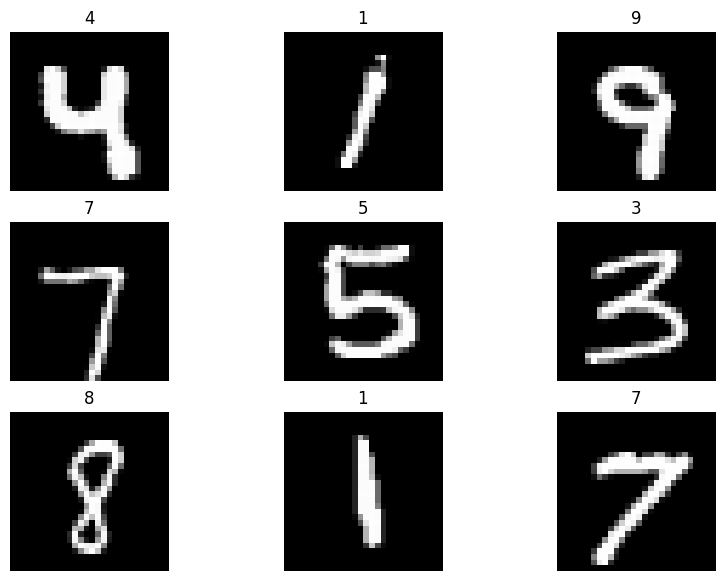

In [21]:
torch.manual_seed(42)

random_idx = torch.randint(0, len(train_data), (9,))
n_rows, n_columns = 3, 3
idx = 1

sample_img, sample_label = next(iter(val_loader))
plt.figure(figsize=(10,7))
for i in range(9):

    plt.subplot(n_rows, n_columns, idx)
    plt.imshow(sample_img[i].permute(1,2,0), cmap='gray')
    plt.axis(False)
    plt.title(sample_label[i].item())
    plt.show
    
    idx += 1

Lastly, let's check the tensors from our dataloaders

In [22]:
sample_img.dtype, sample_label.dtype # Pytorch loves float32!

(torch.float32, torch.int64)

## 4. Create a CNN

In [23]:
import torch.nn as nn

class DigitRecognizerModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_features, kernel_size):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                     out_channels=hidden_channels,
                     kernel_size=kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,
                     out_channels=hidden_channels,
                     kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,
                     out_channels=hidden_channels,
                     kernel_size=kernel_size),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,
                     out_channels=hidden_channels,
                     kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_channels*5*5,
                     out_features=out_features)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
model = DigitRecognizerModel(in_channels = 1,
                            hidden_channels = 16,
                            out_features = len(classes),
                            kernel_size = 2).to(device)
model

DigitRecognizerModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=10, bias=True)
  )
)

### 4.1 Test a forward pass to check dimensions

In [26]:
img_sample = torch.randn((1,28,28)).unsqueeze(dim=0).to(device)
model(img_sample)

tensor([[-0.1084,  0.0482,  0.0190,  0.0289,  0.1350,  0.0102,  0.0080, -0.0903,
          0.1193, -0.0307]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 4.2 Create a train pass function and test pass function

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                           lr=0.1)
softmax = nn.Softmax(dim=1)

In [28]:
accuracy = Accuracy(task="multiclass", num_classes=len(classes)).to(device)

In [29]:
# Testing softmax output
sample_softmax = torch.randn(size=(5,10)).to(device)
torch.argmax(softmax(sample_softmax), dim=1) # It is important to write the target dimension!

tensor([2, 5, 7, 0, 6], device='cuda:0')

In [30]:
def train_pass(model, dataloader, loss_fn, accuracy, softmax, device):
    
    total_loss = 0
    total_acc = 0
    
    model.train()
    
    for X, y in dataloader:
        
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_logits = model(X)
        y_preds = torch.argmax(softmax(y_logits), dim=1).to(torch.int64)
                
        # 2. Loss
        loss = loss_fn(y_logits, y)
        total_loss += loss
        total_acc += accuracy(y_preds, y)
        
        # 3. Zero grad
        optimizer.zero_grad()
        
        # 4. Backward
        loss.backward()
        
        # 5. Step
        optimizer.step()
        
    train_loss = total_loss / len(dataloader)
    train_acc = total_acc / len(dataloader)
    
    return train_loss, train_acc

In [31]:
def test_pass(model, dataloader, loss_fn, accuracy, softmax, device):
    
    total_loss = 0
    total_acc = 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            y_logits = model(X)
            y_preds = torch.argmax(softmax(y_logits), dim=1).to(torch.int64)
        
            # 2. Metrics
            total_loss += loss_fn(y_logits, y)
            total_acc += accuracy(y_preds, y)
            
        test_loss = total_loss / len(dataloader)
        test_acc = total_acc / len(dataloader)
        
    return test_loss, test_acc

In [32]:
epochs = 20

for epoch in range(epochs):
    train_loss, train_acc = train_pass(model, train_loader, loss_fn, accuracy, softmax, device)
    val_loss, val_acc = test_pass(model, val_loader, loss_fn, accuracy, softmax, device)
    
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train accuracy: {train_acc*100:.4f}% | Validation loss: {val_loss:.4f} | Validation accuracy: {val_acc*100:.4f}%")

Epoch: 1 | Train loss: 0.6479 | Train accuracy: 77.7584% | Validation loss: 0.1595 | Validation accuracy: 95.1362%
Epoch: 2 | Train loss: 0.1284 | Train accuracy: 95.9910% | Validation loss: 0.0987 | Validation accuracy: 96.8993%
Epoch: 3 | Train loss: 0.1002 | Train accuracy: 96.8129% | Validation loss: 0.0797 | Validation accuracy: 97.6289%
Epoch: 4 | Train loss: 0.0819 | Train accuracy: 97.3924% | Validation loss: 0.0913 | Validation accuracy: 96.9561%
Epoch: 5 | Train loss: 0.0717 | Train accuracy: 97.6230% | Validation loss: 0.0790 | Validation accuracy: 97.3614%
Epoch: 6 | Train loss: 0.0651 | Train accuracy: 97.9837% | Validation loss: 0.0716 | Validation accuracy: 97.7991%
Epoch: 7 | Train loss: 0.0588 | Train accuracy: 98.1280% | Validation loss: 0.0902 | Validation accuracy: 97.0655%
Epoch: 8 | Train loss: 0.0548 | Train accuracy: 98.2320% | Validation loss: 0.0611 | Validation accuracy: 98.2004%
Epoch: 9 | Train loss: 0.0510 | Train accuracy: 98.3355% | Validation loss: 0.07

## 5. Make predictions with test data

In [33]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
len(test_loader), len(test_data)

(875, 28000)

In [35]:
next(iter(test_loader)).shape

torch.Size([32, 1, 28, 28])

In [36]:
predict = torch.empty((0,), dtype=torch.int64).to(device)
torch.cat((predict, torch.randn((1,)).to(device)), dim=0)

tensor([-0.2858], device='cuda:0')

In [37]:
model.eval()
with torch.inference_mode():
    
    predict = torch.empty((0,), dtype=torch.int64).to(device)
    
    for X in test_loader:
        
        X = X.to(device)
    
        # 1. Forward pass
        y_logits = model(X)
        y_preds = torch.argmax(softmax(y_logits), dim=1)
        
        predict = torch.cat((predict, y_preds), dim=0)

In [38]:
predict_np = predict.cpu().numpy()
index = np.arange(1, len(predict_np) + 1, step=1)
predict_df = pd.DataFrame(data={'ImageId': index, 'Label': predict_np})
predict_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [39]:
predict_df.to_csv('submission.csv', index=False)

### 5.1. Show predictions

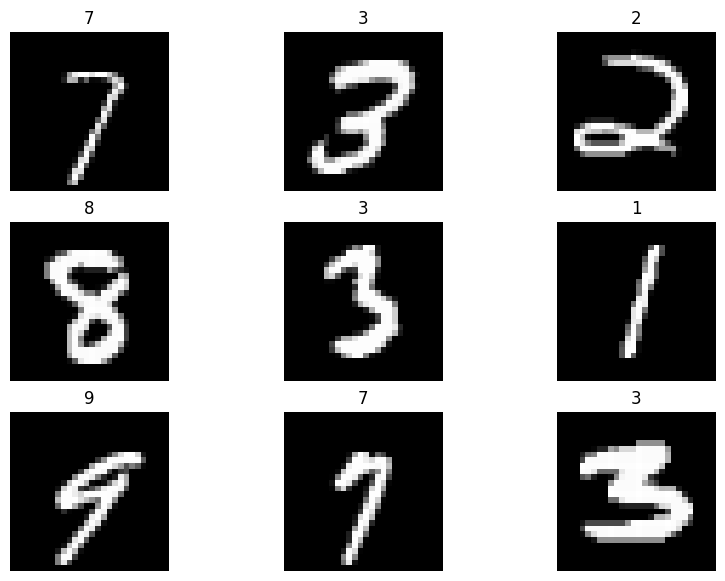

In [40]:
# torch.manual_seed(42)

plt.figure(figsize=(10,7))
random_idx = torch.randint(0, len(predict_df), (9,))
# random_idx = torch.arange(0, 9, step=1, dtype=torch.int64)
n_rows, n_columns = 3, 3
idx = 1

for i in random_idx:
    img = test_data_object[i]
    label = predict_np[i]
    
    plt.subplot(n_rows, n_columns, idx)
    plt.imshow(img.permute(1,2,0), cmap='gray')
    plt.axis(False)
    plt.title(label)
    
    idx += 1